# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [3]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [4]:
import numpy as np

def principalComponentAnalysis(X, numComponents):
    """
    Implement PCA in the following function by taking the following arguments:
    1. X (images array)
    2. numComponents (number of components)
    
    The function must return the eigenvalues, eigenvectors, principal components, and mean of the input data.
    """
    
    '''
    STEPS OF PCA are :
    STEP1 : Obtain the X_images and reduce the dimensions of the image matrix and call it X_reduced , we are already passing the flattened image that is 360,112,92 --> 360,10304
    STEP2 : Now calculate the mean for the X_reduced matrix name it as X_mean
    STEP3 : Now in this step we find the covariance
            Covariance(Xi,Yj) == 1/(N-1) *[(Xi - mean(Xi)) * (Yj - mean(Yj))]
            
            For easy calc'n we consider X_reduced - X_mean ==> S_mat
    STEP4 : Now find the Covariance Matrix of the S_mat
    STEP5 : Calculate the EIGEN VALUES and VECTORS of the covariance matrix
    STEP6 : Now we sort the Eigen Values in the descending order and according to the obtained indices in the descending sorted order we re-arrange the Eigen Vectors
    STEP7 : After obtaining the highest valued Eigen_vectors we obtain the first num_features components

    '''
    X_reduced = X.reshape(X.shape[0], -1) #step 1
    X_mean = np.mean(X_reduced, axis=0) #step 2

    S_mat = X_reduced - X_mean          #step 4

    Covariance_mat = np.cov(S_mat, rowvar=False)        #step 4

    Eigen_values, Eigen_vectors = np.linalg.eigh(Covariance_mat)        #step 5

    indices = np.argsort(Eigen_values)[::-1]
    Eigen_values = Eigen_values[indices]
    Eigen_vectors = Eigen_vectors[:, indices]           #step 6

    Princ_Components = Eigen_vectors[:, :numComponents]         #step 7

    #Princ_Components = np.dot(S_mat.T, Princ_Components)

    return Eigen_values, Eigen_vectors, Princ_Components, X_mean


In [5]:
from tqdm import tqdm
n = 360
train_dataset = []
for i in trainFaces:
    train_dataset.append(i.flatten())
train_dataset = np.array(train_dataset)

E_values , E_vectors , Prin_comps_main, Mean_img = principalComponentAnalysis(trainFaces , n)
Prin_comps = Prin_comps_main[:, :100]


In [6]:
Prin_comps.shape

(10304, 100)

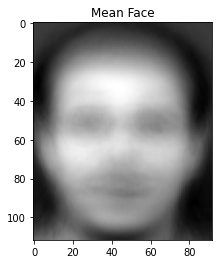

In [7]:
# mean faces showing
imageshape = [112,92]
plt.imshow(Mean_img.reshape(imageshape), cmap='gray')
plt.title("Mean Face")
plt.show()


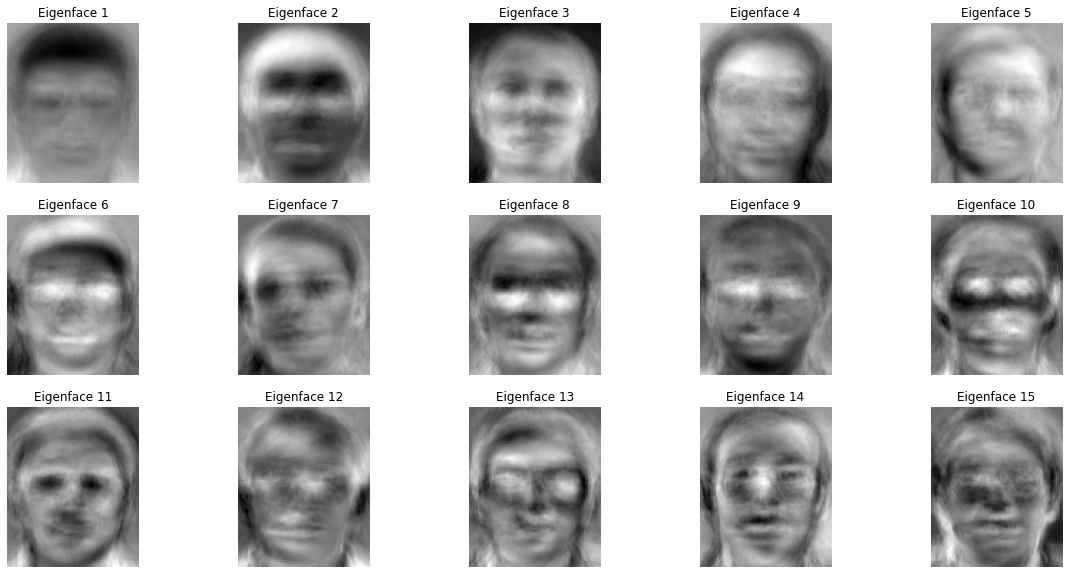

In [8]:
# plot the eigen faces
%matplotlib inline
# projecting the eigen faces i.e the Princ_components
Eigen_Faces = Prin_comps.T

plt.figure(figsize=(20, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(Eigen_Faces[i].reshape(112, 92), cmap='gray')
    plt.title(f'Eigenface {i+1}')
    plt.axis('off')

plt.show()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [9]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
    '''
    STEP1 : Firstly we flatten the test image, in this case we are already passing the flattened image that is 360,112,92 --> 360,10304
    STEP2 : Then similar step to PCA we find the S_mat, since S_mat refers to X_red - X_mean here the X_mean is the MeanFace
    STEP3 : We now need to get the projection of the test image onto the Eigen Faces so for that we dot product the S_mat and the Eigen faces
    STEP4 : Now for the reconstruction of the face of the testimage we are going to use the mean projections obtained and Eigen Faces
    STEP5 : return the reconstructed face of the test image
    '''

    testFace = testFace.flatten()
    
    S_mat = testFace - Mean_img     #step 2

    projections = np.dot(S_mat , eigenFaces)

    reconstructed = np.dot(projections , eigenFaces.T)
    reconstructed += meanFace
    # your code here   

    return reconstructed  


In [10]:
test_dataset = []
test_shape = None 
for i in testFaces:
    test_shape = i.shape
    test_dataset.append(i.flatten())
test_dataset = np.array(test_dataset)

new_faces = []

#we need to apply imagereconstruction on every image in the Test dataset
for test_face in testFaces:
    new_face = imageReconstruction(test_face , Prin_comps , Mean_img)
    new_face = new_face.reshape(test_shape)
    new_faces.append(new_face)


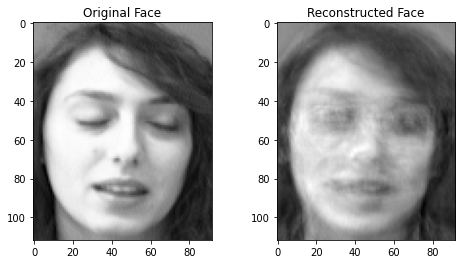

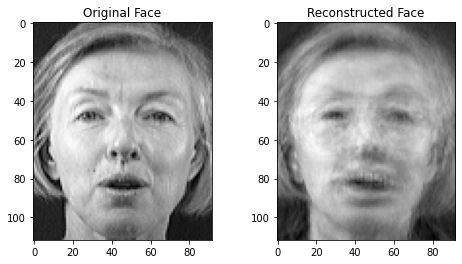

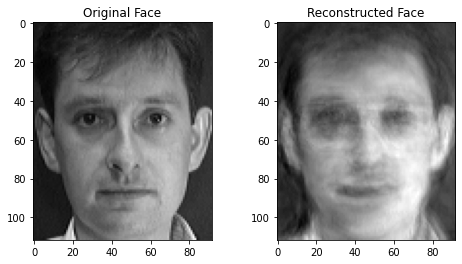

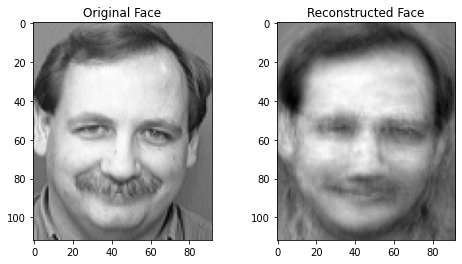

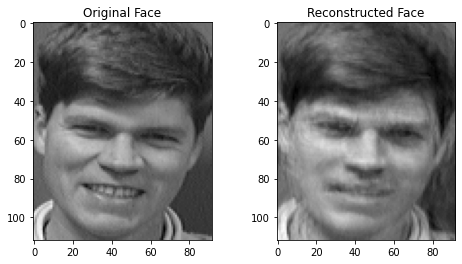

In [11]:
# plot recontructions here
%matplotlib inline
x = 0
for original, reconstructed in zip(testFaces, new_faces):
    if(x == 5):
        break
    x+=1
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Face')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('Reconstructed Face')

    plt.show()

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)


**Note:** Ensure that the images are labelled appropriately.

In [12]:
%matplotlib inline
#trainFace , Prin_comps , Mean_img
def displayNfactors(factors):

    # TASK HERE IS TO GIVE THE EIGEN FACES FOR DIFFERENT VALUES OF NUMBER OF PRINCIPLE COMPONENTS EXTRACTED
    prin_comps = Prin_comps_main[: , :factors] 
    print("number of factors considered is : {factors}")
    fig, pic = plt.subplots(1, 5, figsize=(15, 3))
    new_faces = []
    x = 0 
    for test_face in testFaces:
        if(x == 5):break
        x+=1
        new_face = imageReconstruction(test_face , prin_comps , Mean_img)
        new_face = new_face.reshape(test_shape)
        new_faces.append(new_face)
 
    for i in range(5):
        pic[i].imshow(new_faces[i], cmap="gray")
        pic[i].axis('off')

    plt.suptitle(f'Eigenfaces for {factors} Components', fontsize=16)
    plt.show()

number of factors considered is : {factors}


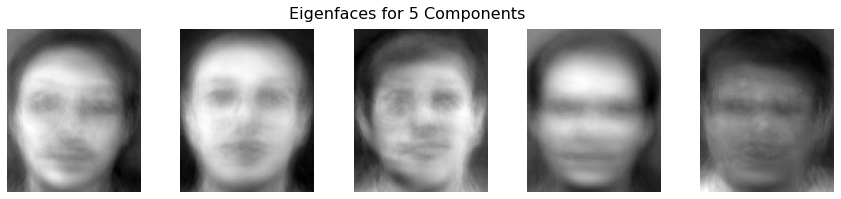

number of factors considered is : {factors}


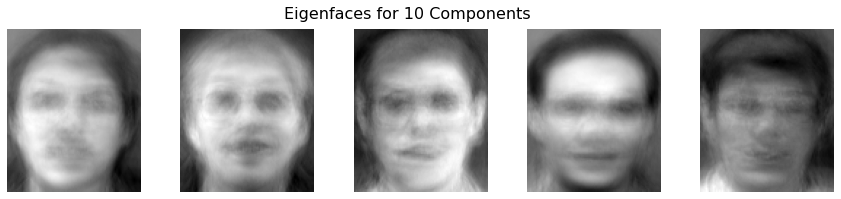

number of factors considered is : {factors}


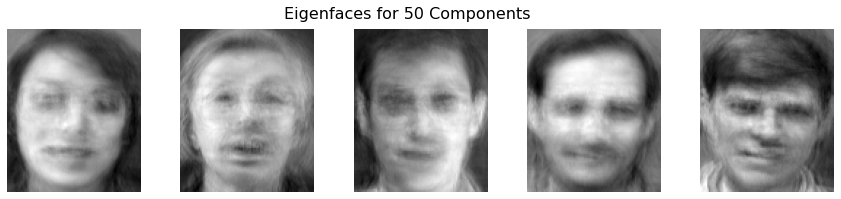

number of factors considered is : {factors}


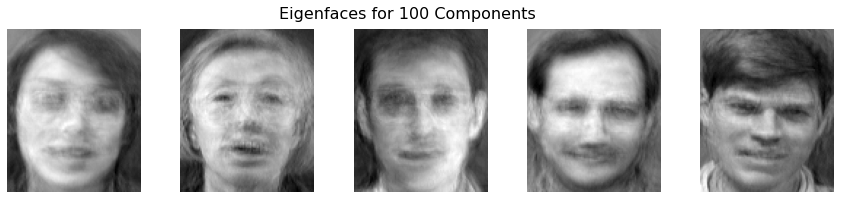

number of factors considered is : {factors}


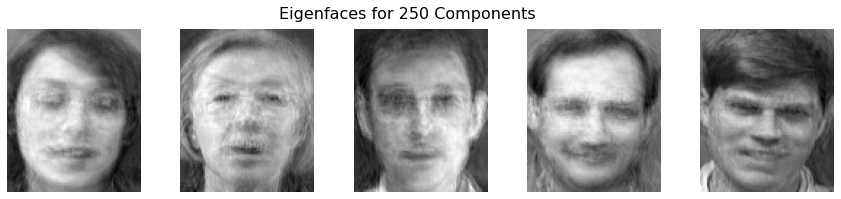

In [13]:
for facts in [5, 10, 50, 100 , 250]:
    displayNfactors(facts)

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [14]:
def getClass(test_img , E_vecs , mean_img , X_train , Y_train):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """
    '''
    STEP1 : Flattening the test image , we are already flattening the image and parsing it to the function
    STEP2 : Find the S_mat using the mean_img
    '''
    test_img1 = test_img.flatten() - Mean_img
    
    train_dataset = []
    for i in trainFaces:
        train_dataset.append(np.dot((i.flatten() - Mean_img.flatten()) , E_vecs))
    train_dataset = np.array(train_dataset)
    
    testing_proj = np.dot(test_img1 , E_vecs)
    

    distances = np.linalg.norm((train_dataset - testing_proj), axis=1)
    nearest_face_index = np.argmin(distances)
    #print(nearest_face_index)

    closest_image = X_train[nearest_face_index].reshape(test_img.shape)
    error = distances[nearest_face_index]**2
    predicted_class = Y_train[nearest_face_index]

    return  closest_image, error, predicted_class

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [15]:
components = [3,5,10,20,25,30]
mse = []
accuracies = []

for numComponents in components:
    # your code here
    #E_vals , E_vecs , pca_vecs , mean_img = principalComponentAnalysis(train_dataset , numComponents)
    pca_vecs = Prin_comps_main[:, :numComponents]
    correct_predictions = 0
    total_mse = 0
    i= 0 
    for test_img in testFaces:
        closest_image, error, predicted_class = getClass(test_img ,pca_vecs , Mean_img , trainFaces , trainLabels )
        total_mse += error 
        
        if(predicted_class ==  testLabels[i]):    correct_predictions+=1
        i+=1

    mse.append(total_mse/len(testFaces))
    accuracies.append(correct_predictions/len(testFaces))


In [16]:
print(accuracies)
print(mse)

[0.65, 0.75, 0.925, 0.95, 0.975, 0.975]
[109824.22849972142, 404045.5434912574, 845659.0010267285, 1452236.1669665729, 1632657.6598122085, 1809766.3637338816]


Plot Number of eigenvectors vs Mean Square Error

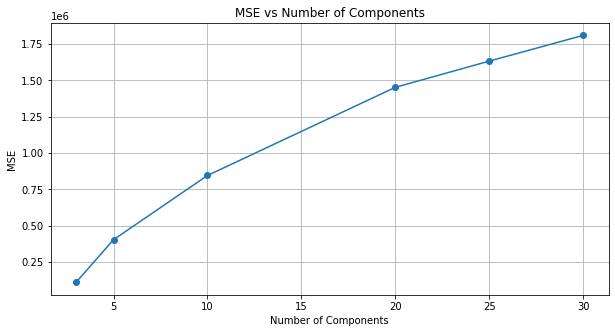

In [17]:
# your code here
plt.figure(figsize=(10, 5))
plt.plot(components,  mse, marker='o')
plt.title('MSE vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

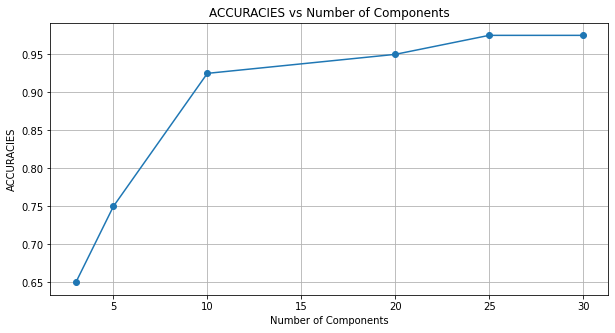

In [18]:
# your code here
plt.figure(figsize=(10, 5))
plt.plot(components,  accuracies, marker='o')
plt.title('ACCURACIES vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('ACCURACIES')
plt.grid(True)
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

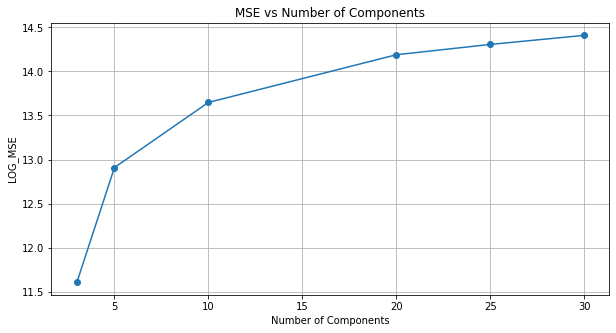

In [19]:
# your code here
log_mse = np.log(mse)
plt.figure(figsize=(10, 5))
plt.plot(components,  log_mse, marker='o')
plt.title('MSE vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('LOG_MSE')
plt.grid(True)
plt.show()